## Standardize molecules

In [3]:
import pandas as pd
import numpy as np
import random
from rdkit.Chem import AllChem
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdkit import RDLogger
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.rdinchi import MolToInchiKey
from rdkit import DataStructs
from rdkit.Chem import Draw

from standardizer.CustomStandardizer import CustomStandardizer
from loaders.Loaders import CSVLoader

from copy import deepcopy

RDLogger.DisableLog('rdApp.*')

seed_value = 123

np.random.seed(seed_value)
random.seed(seed_value)

## Standardize sweet, bitter, and tasteless compounds

In [3]:



def standardize(dataset_file_path, label):
    
    loader = CSVLoader(dataset_file_path,
                       id_field = "id",
                       mols_field='smiles',
                       labels_fields=label)

    dataset_to_test = loader.create_dataset()

    standardisation_params = {
        'REMOVE_ISOTOPE': True,
        'NEUTRALISE_CHARGE': True,
        'REMOVE_STEREO': False,
        'KEEP_BIGGEST': True,
        'ADD_HYDROGEN': False,
        'KEKULIZE': True,
        'NEUTRALISE_CHARGE_LATE': True}
    
    CustomStandardizer(params = standardisation_params).standardize(dataset_to_test)
    
    return dataset_to_test

# Standardize sweet and the rest of the database
sweetness_dataset = standardize("../data_test/sweeteness_dataset_v3_1.csv", "sweet")
# Save clean compounds
sweetness_dataset.save_to_csv("../data_test/clean_sweeteness_dataset_v3_1.csv")
# Standardize bitter molecules
bitter_molecules = standardize("../data_test/bitter_molecules.csv", "bitter")
# Save clean bitter molecules
bitter_molecules.save_to_csv("../data_test/clean_bitter_molecules.csv")


Standardizing datapoint 0
Standardizing datapoint 1000
Standardizing datapoint 2000
Standardizing datapoint 3000
Standardizing datapoint 4000
Standardizing datapoint 5000
Standardizing datapoint 6000
Standardizing datapoint 7000
Standardizing datapoint 8000
Standardizing datapoint 9000
Standardizing datapoint 10000
Standardizing datapoint 11000
Standardizing datapoint 12000
Standardizing datapoint 13000
Standardizing datapoint 14000
Standardizing datapoint 15000
Standardizing datapoint 16000
Standardizing datapoint 17000
Standardizing datapoint 18000
Standardizing datapoint 19000
Standardizing datapoint 20000
Standardizing datapoint 21000
Standardizing datapoint 22000
Standardizing datapoint 23000
Standardizing datapoint 24000
Standardizing datapoint 25000
Standardizing datapoint 26000
Standardizing datapoint 27000
Standardizing datapoint 28000
Standardizing datapoint 29000
Standardizing datapoint 30000
Standardizing datapoint 31000
Standardizing datapoint 32000
Standardizing datapoint

## Drop duplicates and remove non-convertable molecules

In [19]:
sweeteners = pd.read_csv("../data_test/clean_sweeteness_dataset_v3_1.csv")
bitter = pd.read_csv("../data_test/clean_bitter_molecules.csv")

In [20]:
print(sweeteners.shape)
print(bitter.shape)

(78848, 3)
(1141, 3)


In [21]:
from copy import copy

def remove_not_convertable_molecules(dataset, structure_column):
    new_dataset = copy(dataset)
    for i, row in dataset.iterrows():
        structure = row[structure_column]

        try:
            mol = MolFromSmiles(structure)
            if mol is None:
                new_dataset = new_dataset.drop(i)

        except:
            new_dataset = new_dataset.drop(i)

    return new_dataset

In [22]:
bitter = bitter.drop_duplicates(subset ="mols",
                     keep = False, inplace = False)

In [23]:
bitter = remove_not_convertable_molecules(bitter, "mols")

In [24]:
sweeteners = sweeteners.drop_duplicates(subset ="mols",
                     keep = False, inplace = False)

In [25]:
sweeteners = remove_not_convertable_molecules(sweeteners, "mols")

In [26]:
print(sweeteners.shape)
print(bitter.shape)

(76764, 3)
(1065, 3)


In [148]:
# save the clean molecules without duplicates and without non-convertable molecules
bitter.to_csv("clean_bitter_molecules.csv", index=False)
sweeteners.to_csv("clean_sweeteness_dataset_v3_1.csv", index=False)

## Function to generate similarities for data visualization

In [28]:
def generate_similarities(smiles):
    fps = []
    similarities_list = []
    for smiles in smiles:
        fp = AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(smiles), 2, 2048)
        #fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(MolFromSmiles(smiles), 
                                                                    #nBits=2048, includeChirality = True)
        fps.append(fp)
    
    if len(fps) > 10000:
        entries = 10000
    else:
        entries = len(fps)
        
    for i in range(0,entries):
        
        remaining_fp = fps[:i] + fps[i+1:]
        similarities = DataStructs.BulkTanimotoSimilarity(fps[i], remaining_fp)
        similarities.insert(i,1)
        similarities_list.append(similarities)
        
    return np.transpose(np.array(similarities_list))

## Sample negative cases and force bitter molecules to be in the dataset

In [32]:


bitter = pd.read_csv("../data_test/clean_bitter_molecules.csv")
molecules_inchikey = []

# generation of inchikeys
for i, row in bitter.iterrows():
    smiles = row["mols"]
    
    mol = MolFromSmiles(smiles)
    if mol:
        inchikey = MolToInchiKey(mol)
        if inchikey:
            molecules_inchikey.append(inchikey)
        
molecules_inchikey[:3]

['STDBAQMTJLUMFW-UHFFFAOYSA-N',
 'ISBWNEKJSSLXOD-UHFFFAOYSA-N',
 'FTOAOBMCPZCFFF-UHFFFAOYSA-N']

### Separate bitter molecules from other molecules

In [33]:
df2 = pd.read_csv("../data_test/clean_sweeteness_dataset_v3_1.csv")
negative_dataset = df2[df2["y"]==0]
negative_dataset = remove_not_convertable_molecules(negative_dataset, "mols")

new_negative_dataset = copy(negative_dataset)

# search for the bitter compounds by inchikey
for i,row in negative_dataset.iterrows():
    smiles = row["mols"]
    mol = MolFromSmiles(smiles)
    if mol:
        inchikey = MolToInchiKey(mol)
        if inchikey in molecules_inchikey:
            new_negative_dataset = new_negative_dataset.drop(i)
            
new_negative_dataset.shape

In [34]:
new_negative_dataset.to_csv("../data_test/negative_cases_without_bitter_compounds.csv", index=False)

### Sample molecules per size

In [36]:
new_negative_dataset = pd.read_csv("../data_test/negative_cases_without_bitter_compounds.csv")

new_negative_dataset_small_mol = deepcopy(new_negative_dataset)
indexes_to_keep = []
for j, row in new_negative_dataset_small_mol.iterrows():
    smiles = row["mols"]
    ids = row["ids"]
    if 35 > len(smiles) > 6:
        indexes_to_keep.append(ids)
        
new_negative_dataset_small_mol = new_negative_dataset_small_mol[new_negative_dataset_small_mol["ids"].isin(indexes_to_keep)]

In [37]:
new_negative_dataset_small_mol.drop_duplicates(subset="mols")

,ids,mols,y
16,266058,COC1=CC=C(C(=O)C2=CC=CC=C2)C=C1,0.0
23,266043,COC1=CC=C(C2OC3=CC=CC=C3OC2C)C=C1O,0.0
30,266055,COC1=CC=C(CC2=CC=CC=C2C(=O)O)C=C1,0.0
32,266017,CC1=C(N)C=CC=C1[N+](=O)[O-],0.0
38,266090,COC1=CC=C(CNCC(C)(C)C)C=C1O,0.0
...,...,...,...
68162,354495,N[C@@H](CO)C(=O)NCC(=O)O,0.0
68167,354501,N[C@@H](CO)C(=O)N1CCC[C@H]1C(=O)O,0.0
68168,354502,N[C@@H](CO)C(=O)N[C@@H](CO)C(=O)O,0.0
68170,354506,NC(CCC(=O)NC(=O)C(N)CO)C(=O)O,0.0


In [38]:
new_negative_dataset_large = deepcopy(new_negative_dataset)
indexes_to_keep = []
for j, row in new_negative_dataset_large.iterrows():
    smiles = row["mols"]
    ids = row["ids"]
    if 35 < len(smiles) < 100:
        indexes_to_keep.append(ids)
        
new_negative_dataset_large = new_negative_dataset_large[new_negative_dataset_large["ids"].isin(indexes_to_keep)]

In [39]:
new_negative_dataset_large.drop_duplicates(subset="mols")

,ids,mols,y
0,265860,OC[C@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@H](O)[C@H...,0.0
1,265864,CO[C@H]1O[C@H](CO)[C@@H](O[C@H]2O[C@H](CO)[C@@...,0.0
2,265874,C[C@@H]1O[C@@H](OC2=C(C(=O)CCC3=CC=C(O)C=C3)C(...,0.0
3,265875,COC1=C(O)C2=C(C=C1O)O[C@H](C1=CC=C(O)C=C1)[C@@...,0.0
4,265876,COC1=C(O)C=C2O[C@H](C3=CC=C(O)C(O)=C3)[C@@H](O...,0.0
...,...,...,...
68216,354590,N[C@@H](CCC(=O)N[C@@H](CO)C(=O)O)C(=O)O,0.0
68217,354591,C[C@@H](O)[C@H](NC(=O)CC[C@H](N)C(=O)O)C(=O)O,0.0
68218,354592,N[C@@H](CCC(=O)N[C@@H](CC1=CNC2=CC=CC=C12)C(=O...,0.0
68219,354593,CCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCC)...,0.0


In [40]:
new_negative_dataset_large_mol = new_negative_dataset_large.sample(n=3000,random_state=seed_value)

In [41]:
new_negative_dataset = new_negative_dataset_large_mol.append(new_negative_dataset_small_mol)

In [42]:
new_negative_dataset.to_csv("../data_test/filtered_negative_cases_without_bitter_compounds.csv", index=False)

### Sample negative cases using k-means on tanimoto similarities

In [ ]:
# WARNING: this operation has a complexity of O(n^2) and consumes a lot of memory
#generate similarities of "Non-sweet" molecules
similarities = generate_similarities(new_negative_dataset["mols"])

In [341]:
from sklearn.manifold import TSNE
# generate tSNE latent space of molecular similarities
tsne_similarities = TSNE(n_components=2, random_state=seed_value).fit_transform(similarities)

/home/jcapela/miniconda3/envs/sweeteners_paper2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jcapela/miniconda3/envs/sweeteners_paper2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [342]:
kmeans = KMeans(n_clusters=10, random_state=seed_value).fit(tsne_similarities)

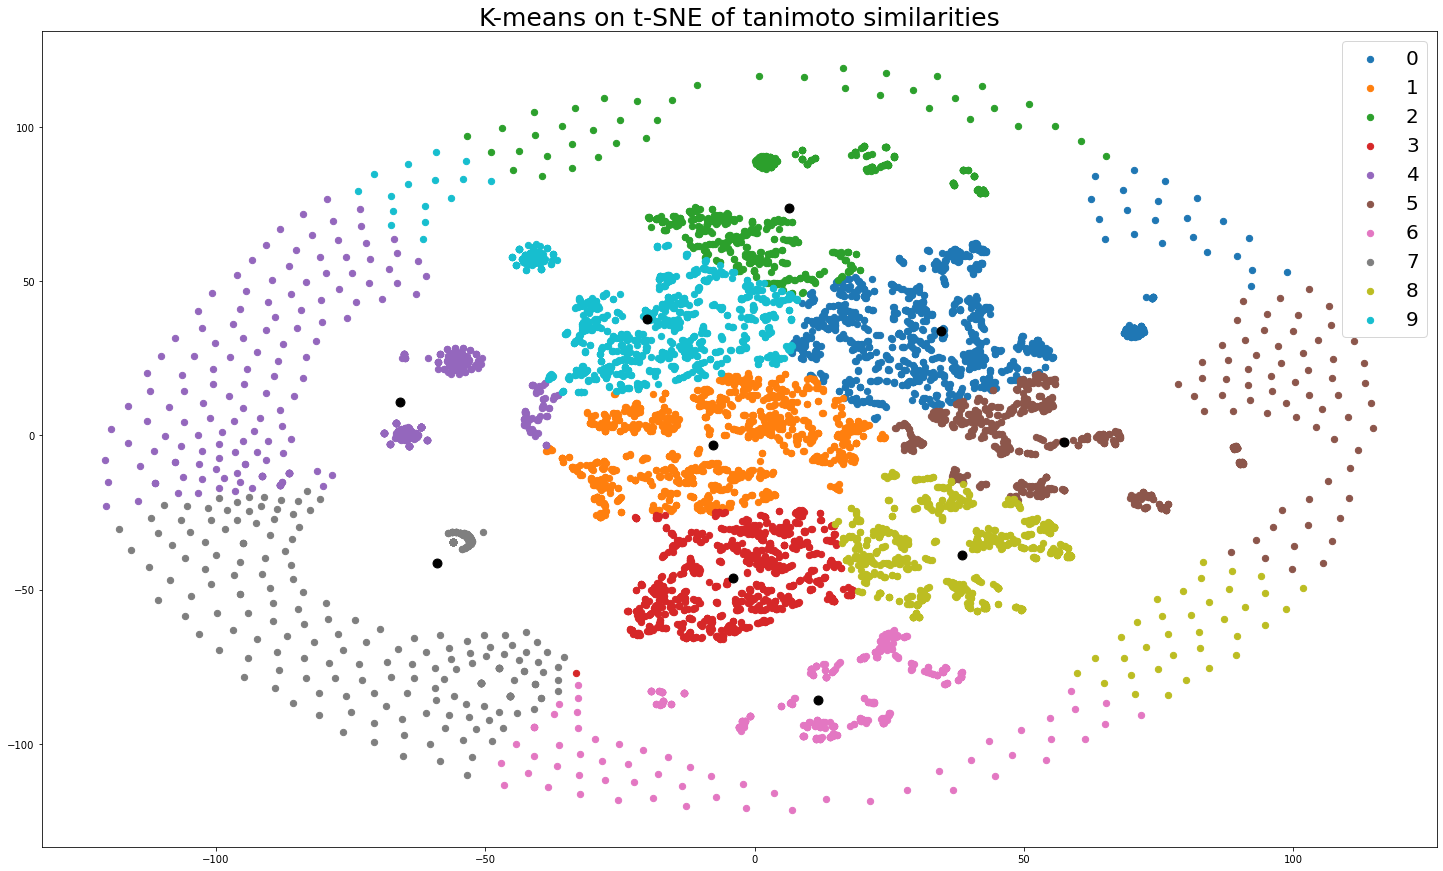

In [343]:
u_labels = np.unique(kmeans.labels_)
plt.subplots(1, figsize=(25, 15))
# plotting the results:
centroids = kmeans.cluster_centers_
for i in u_labels:
    plt.scatter(tsne_similarities[kmeans.labels_ == i, 0], tsne_similarities[kmeans.labels_ == i, 1], label=i, s=40)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
plt.legend(prop={'size': 20})
plt.title("K-means on t-SNE of tanimoto similarities", fontsize=25)
plt.show()

In [344]:
print(kmeans.cluster_centers_)
print(kmeans.inertia_)
print(kmeans.inertia_)

[[ 34.61861    33.966698 ]
 [ -7.7150397  -2.9982057]
 [  6.309666   73.83974  ]
 [ -4.021977  -46.21121  ]
 [-65.85736    10.975989 ]
 [ 57.393482   -2.0067167]
 [ 11.7639885 -85.80217  ]
 [-58.946507  -41.261734 ]
 [ 38.467823  -38.894238 ]
 [-19.95002    37.65404  ]]
3956253.0
3956253.0


### Get the centroid nearest compounds

In [378]:
indexes_to_add = []
for i in range(10):
    d = kmeans.transform(tsne_similarities)[:, i]
    inds = np.argsort(d)[::][:760]
    for ind in inds:
        if ind not in indexes_to_add:
            indexes_to_add.append(ind)
indexes_to_add

In [379]:
len(np.unique(np.array(indexes_to_add)))

6989

In [380]:
len(np.array(indexes_to_add))

6989

In [381]:
undersampled_negative_dataset = new_negative_dataset.iloc[indexes_to_add,:]

In [382]:
bitter = pd.read_csv("../data/clean_bitter_molecules.csv")
bitter

,ids,mols,y
0,265473,CCCCC1(CC)C(=O)NC(=O)NC1=O,0
1,265383,CCCCOC(=O)CCC(C)=O,0
2,265483,CCC1(CC)C(=O)NC(=O)NC1=O,0
3,265471,C=CCC1(CC=C)C(=O)NC(=O)NC1=O,0
4,265486,CC1(C2=CC=CC=C2)C(=O)NC(=O)NC1=O,0
...,...,...,...
1060,265288,NCC(=O)NC(CC1=CC=CC=C1)C(=O)O,0
1061,266883,N[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H](CC1=CNC2=C1C...,0
1062,265286,NC(N)=NCCCC(NC(=O)C1CCCN1)C(=O)O,0
1063,291854,NC(CC1=CNC2=CC=CC=C12)C(=O)NC(CC1=CC=CC=C1)C(=O)O,0


In [383]:
bitter["y"] = [0]*bitter.shape[0]
final_negative_dataset = undersampled_negative_dataset.append(bitter)

In [384]:
df = pd.read_csv("../data/clean_sweeteness_dataset_v3_1.csv")
positive_dataset = df[df["y"]==1]

In [385]:
final_binary_classification_dataset = positive_dataset.append(final_negative_dataset)


In [386]:
pre_processed_dataset = deepcopy(final_binary_classification_dataset)
indexes_to_remove = []
for j, row in final_binary_classification_dataset.iterrows():
    smiles = row["mols"]
    if len(smiles) < 6:
        indexes_to_remove.append(j)
        
pre_processed_dataset = pre_processed_dataset.drop(indexes_to_remove)
pre_processed_dataset.to_csv("../data/preprocessed_sweeteners_dataset.csv", index=False)

## Analysis on the latent molecular space

In [4]:
def get_molecules_per_coordinates(df,sweeteners_dataset,x0,x1,y0,y1, class_label):

    cluster_molecules = []
    labels = sweeteners_dataset["y"]
    for i, coord in enumerate(df):
        if x0 < coord[0] < x1 and y0 < coord[1] < y1 and labels[i] == class_label:
            cluster_molecules.append(sweeteners_dataset.at[i,"mols"])

    return cluster_molecules

from rdkit import DataStructs

def get_similarity(query_seq, cluster_molecules):
    fps = []
    for mol in cluster_molecules:
        fp = AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(mol),2,nBits=2048)
        fps.append(fp)

    query_fp = \
    AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(query_seq),2,nBits=2048)

    scores = DataStructs.BulkTanimotoSimilarity(query_fp, fps)
    return np.mean(scores)

from rdkit.Chem import MolFromSmarts

def highlight_atoms_with_query(lst,smarts):
    to_highlight = []
    for mol in lst:
        mol = MolFromSmiles(mol)
        final_tuple = ()
        lst_idx = mol.GetSubstructMatches(smarts)
        for idx in lst_idx:
            final_tuple = final_tuple + idx


        to_highlight.append(final_tuple)
    return to_highlight

def get_percentage_carbohydrate_monomer(cluster_molecules):

    smarts = MolFromSmarts("[Or5,Or6,Or7,Or8]")
    counter = 0
    for mol in cluster_molecules:
        mol = MolFromSmiles(mol)
        isMonossacharide = mol.HasSubstructMatch(smarts)
        if isMonossacharide:
            counter+=1

    return counter/len(cluster_molecules), counter, len(cluster_molecules)

def get_percentage_amino_acid(cluster_molecules):

    smarts = MolFromSmarts("[NX3,NX4+][CX4H]([*])[CX3](=[OX1])[O,N]")
    counter = 0
    for mol in cluster_molecules:
        mol = MolFromSmiles(mol)
        isPeptide = mol.HasSubstructMatch(smarts)
        if isPeptide:
            counter+=1

    return counter/len(cluster_molecules), counter, len(cluster_molecules)


In [5]:
sweeteners_dataset = pd.read_csv("../data/preprocessed_sweeteners_dataset.csv")

In [6]:
sweeteners_dataset.shape

(16052, 3)

In [103]:
similarities = generate_similarities(sweeteners_dataset["mols"])

tsne_df = TSNE(n_components=2,random_state=123).fit_transform(similarities)
import matplotlib.pyplot as plt
import seaborn as sns

labels = sweeteners_dataset.loc[:,"y"]

string_labels = []
for label in labels:
    if label == 1:
        string_labels.append("Sweet")
    else:
        string_labels.append("Not Sweet")

/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


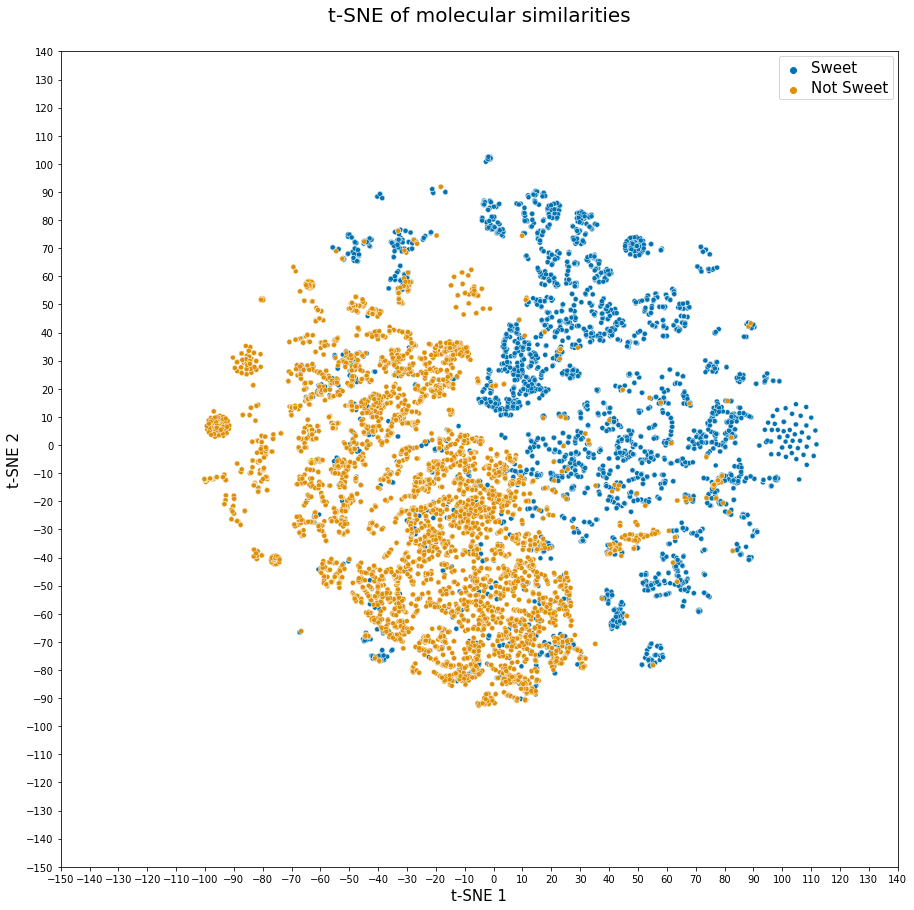

<Figure size 1080x1080 with 0 Axes>

In [104]:
fig, ax = plt.subplots()
plt.figure(figsize=(15, 15))
sns.scatterplot(
    tsne_df[:, 0], tsne_df[:, 1],
    hue=string_labels,
    palette=sns.color_palette("colorblind", 2),
    legend="full",
    s=25,
    ax=ax
)

ax.set_title("t-SNE of molecular similarities", 
                       fontdict= { 'fontsize': 20 }, pad= 30)

plt.setp(ax.get_legend().get_texts(), fontsize='15')
ax.set_xticks(range(-150,150,10))
ax.set_yticks(range(-150,150,10))
fig.set_size_inches(15,15)
ax.set_xlabel("t-SNE 1", fontsize='15')
ax.set_ylabel("t-SNE 2", fontsize='15')
plt.show()

### Get molecules of the "Blend set"

In [148]:
# sweeteners from the upper part
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-110,0,10,110, 1)
len(cluster_molecules)

974

In [149]:
# sweeteners from the down part
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-110,32,-110,10, 1)
len(cluster_molecules)

1565

In [152]:
# non-sweeteners from the upper part
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-110,0,10,110, 0)
len(cluster_molecules)

2495

In [153]:
# non-sweeteners from the down part
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,-110,32,-110,10, 0)
len(cluster_molecules)

5338

### Get percentage of molecules with amino-acid moieties in the green region

In [155]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,0,110,10,110, 1)
get_percentage_amino_acid(cluster_molecules)

(0.6670757901196686, 2174, 3259)

In [156]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,0,110,10,110, 0)
get_percentage_amino_acid(cluster_molecules)

(0.6666666666666666, 22, 33)

### Get percentage of molecules with at least one oxygen in rings in the red region

In [150]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,32,110,-110,10, 1)
get_percentage_carbohydrate_monomer(cluster_molecules)

(0.9333635539437897, 2059, 2206)

In [154]:
cluster_molecules = get_molecules_per_coordinates(tsne_df,sweeteners_dataset,32,110,-110,10, 0)
get_percentage_carbohydrate_monomer(cluster_molecules)

(0.9382022471910112, 167, 178)

## Draw molecules in these regions

### Green region (region on the right top mostly with sweeteners)

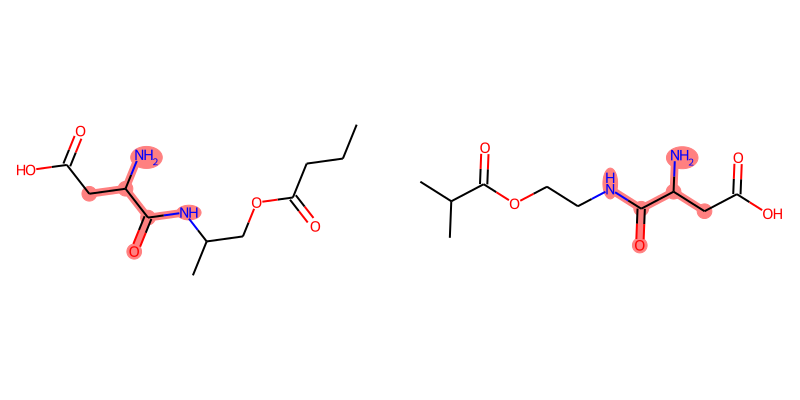

In [228]:
smarts = MolFromSmarts("[NX3,NX4+][CX4H]([*])[CX3](=[OX1])[O,N]")
to_highlight = highlight_atoms_with_query(cluster_molecules[3:5],smarts)
Draw.MolsToGridImage([MolFromSmiles(mol) for mol in cluster_molecules[3:5]],highlightAtomLists=to_highlight, molsPerRow=2, subImgSize=(400,400))

### Red region (region on the right bottom mostly with sweeteners)

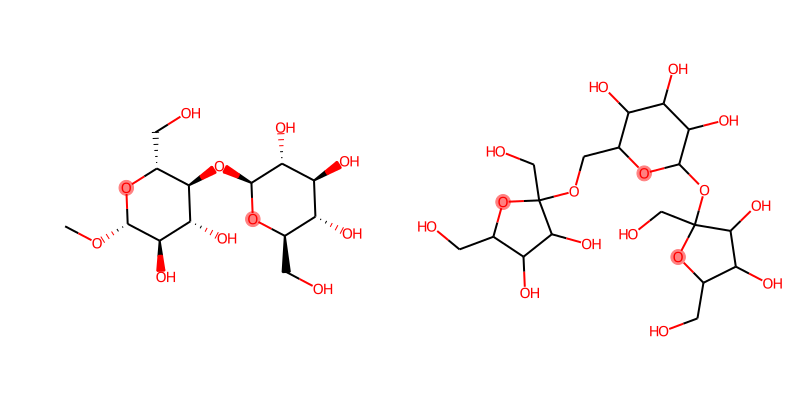

In [221]:
to_highlight = highlight_atoms_with_query(cluster_molecules[99:102],smarts)
Draw.MolsToGridImage([MolFromSmiles(mol) for mol in cluster_molecules[99:101]],highlightAtomLists=to_highlight, molsPerRow=2, subImgSize=(400,400))

In [138]:
cluster_size = 0
cluster_molecules = []
for i, coord in enumerate(tsne_df):
    if -25 < coord[1] < 50 and 30 > coord[0] > -70 and labels[i] == 0:
        cluster_size+=1
        cluster_molecules.append(sweeteners_dataset.at[i,"mols"])
        #print(sweeteners_dataset.at[i,"mols"])
        
cluster_size

1970